In [1]:
import numpy as np
import matplotlib.pyplot as plt

Exploring tabluar Q learning.
What are the limits of its efficiency?

In [49]:
n_actions = 16
n_states = 64
gamma = 0.999
H = 100  # number of time steps in a episode
K = 1000  # number of episodes

In [50]:
# utils
def onehot(idx, N):
    return np.eye(N)[idx]

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [51]:
class Env():
    def __init__(self, n_states, n_actions):
        self.S = np.arange(n_states)
        self.A = np.arange(n_actions)

        # model the transitions as linear fns conditional on the action.
        # P = np.random.standard_normal([n_actions, n_states, n_states]) **2 # make sharper

        # deterministic transition fn
        # each action move from state(i) to state(j) with probability 1.
        # BUG nope. softmax doesnt do this. will need to set to -infty
        self.P = 20*np.stack([np.random.permutation(np.eye(n_states, dtype=np.float32)) for _ in range(n_actions-1)] + [np.eye(n_states, dtype=np.float32)],axis=0)  
        # TODO what if there is structure in P? Low rank? Shared over actions?
        # QUESTION how does this parameterisation effect things?
        # NOTE this graph might be disconnected. but is unlikely!?

        # reward is only a fn of the current state - shape = [n_states]
        # also. is sparse.
        self.R = onehot(np.random.randint(0, n_states), n_states)

    def step(self, state, action):
        """
        A tabular, probabilistic step function. 

        Args:
            state (int): An element of S. The current state
            state (int): An element of A. The action to be taken

        Returns:
            new_state (int): An element of S.
        """
        # step by selecting relevant transition matrix and applying
        logits = np.matmul(self.P[action, ...], onehot(state, n_states))
        # convert to a distribution and sample
        new_s = np.random.choice(self.S, p=softmax(logits))
        return new_s, self.R[new_s]
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.A)
    
    def reset(self):
        return np.random.choice(self.S)

env = Env(n_states, n_actions)
env.step(0, env.rnd_policy(env.reset()))

(59, 0.0)

In [52]:
class QLearner():
    def __init__(self, n_states, n_actions, util_fn):
        self.gamma = 0.9
        self.lr = 0.001
        self.util_fn = util_fn

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = self.util_fn(s, self.qs)
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, self.old_r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
        self.old_r = r
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        # wait a minute. in https://arxiv.org/abs/1807.03765 they actually update 
        # the q values with the uncertainty estimates. delta + bt. hmph
        # why would you combine them??? 
        # oh. If you dont combine them then you are doing offpolicy...!?
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!

In [53]:
class EpsilonGreedy():
    def __init__(self, action_space, epsilon=0.9):
        self.action_space = action_space
        self.epsilon = epsilon

    def __call__(self, s, qs):
        if np.random.random() > self.epsilon:
            a = np.random.choice(self.action_space)
        else:
            a = np.argmax(qs[s, ...])
        return a
    
class UCB_Hoeffding():
    def __init__(self, action_space):
        self.counts = np.zeros([n_states, n_actions])
        self.action_space = action_space

    def __call__(self, s, qs):
        util = qs[s, ...] + 1/np.sqrt(self.counts[s, ...]+1)  # utility = exploit + explore
        p = softmax(util)
        a = np.random.choice(self.action_space, p=p)

        self.counts[s, a] += 1

        return a
    
class UCB_Berkenstein():
    def __init__(self):
        # hmm. need access to past q vals!? so we can estimate variance
        # will need to reoganise code...
        self.var_estimate = None
        
    def __call__(self, s, qs):
        pass

In [54]:
def play_episode(env, player, len_episode):
    # reset
    s = env.reset()
    total_r = 0
    r = 0
    
    # play an episode
    for _ in range(len_episode):
        s, r = env.step(s, player(s, r))
        total_r += r
        
    return total_r/K

In [55]:
def eval_player(env, player, len_episode, n_episodes):
    """
    Args:
        env: must have a callable env.step fn that takes [state x action)s and returns (new_state, reward)
        player: a callable fn that returns actions given the current state
        
    Returns:
        Rs: Rewards as a fn of time
    """
    Rs = []
    for i in range(n_episodes):

        r = play_episode(env, player, len_episode)
        Rs.append(r)

#         print('\rStep: {}, R: {}'.format(i, r), end='', flush=True)

    return Rs

In [56]:
def eval_env(n_states, n_actions, len_episode, n_episodes):
    env = Env(n_states, n_actions)
    trials = []
    for i in range(50):
        print('\rStep: {}'.format(i), end='', flush=True)
        rnd_Rs = eval_player(env, env.rnd_policy, len_episode, n_episodes)

        player = QLearner(n_states, n_actions, UCB_Hoeffding(env.A))
        q_ucb_Rs = eval_player(env, player, len_episode, n_episodes)


        player = QLearner(n_states, n_actions, EpsilonGreedy(env.A))
        q_eps_Rs = eval_player(env, player, len_episode, n_episodes)

        trials.append((rnd_Rs, q_ucb_Rs, q_eps_Rs))
    return trials

trails = eval_env(n_states, n_actions, 100, 1000)
rnd, q_ucb, q_eps = zip(*trials)

Step: 49

In [57]:
def trial_stats(trials):
    trials = np.array(trials)
    mean = np.sum(trials, axis=0)/trials.shape[0]
    std = np.sqrt(np.sum((trials-mean)**2, axis=0))
    return mean, std

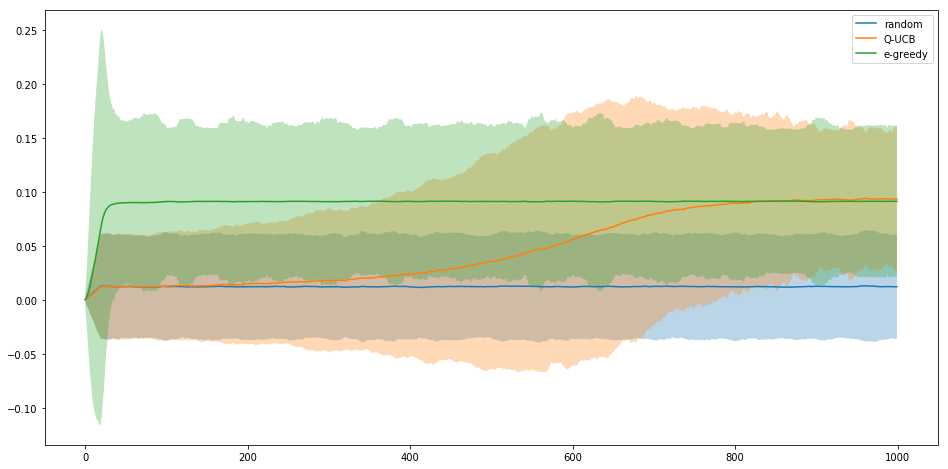

In [58]:
def plot(x, label):
    n = len(x[0])
    idx = range(n)
    mean, std = trial_stats(x)
    
    # smooth the signals
    n_kernel = 20
    kernel = [1]*n_kernel
    mean = np.convolve(mean, kernel)[:n]/n_kernel
    std = np.convolve(std, kernel)[:n]/n_kernel
    
    # plot
    plt.plot(idx, mean, label=label)
    plt.fill_between(idx, mean-std, mean+std,  alpha=0.3)

plt.figure(figsize=(16, 8))
plot(rnd, label='random')
plot(q_ucb, label='Q-UCB')
plot(q_eps, label='e-greedy')
plt.legend()

Observation: A higher loss leads to an unstable point for UCB. It reliably achieves high reward, quite quickly, but then diverges.
e-greed is far more stable.

Explanation (?): If UCB forgets something important (by taking a step that is too large), it is not able to rediscover it (as the counts are now large and little exploration is being done).

Could be fixed by remembering the maximum R achieved so far!?

In [59]:
def regret(x, x_star=1.0):
    # best possible reward is can be gained by staying in the
    # same place. so is upper bounded by 1. 
    # the reward for being in that place
    # it possible to achieve if you get luck and randomly init in the right spot
    # (and no noise pushes you off it)
    return np.sum(x_star-x)

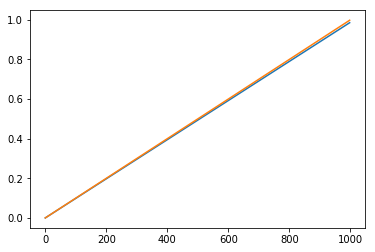

In [61]:
mean, std = trial_stats(rnd)

regrets = [regret(mean[:i]) for i in range(len(mean)-1)]
plt.plot(np.array(regrets)/1000)
plt.plot(np.arange(len(mean)-1)/1000)

It looks pretty linear to me. Suggesting there is a large amount of efficiency to be gained?
Or mybe it is really scaling at $O(\sqrt T)$, but only for larger N.

For small $T, y = at \approx a\sqrt T$!?!?!?!?
Maybe other terms are dominating the cost? But they shouldnt be changing with T?

https://github.com/pberkes/big_O

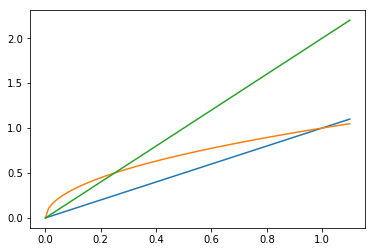

In [77]:
x = np.linspace(0, 1.1, 100)
plt.plot(x, x)
plt.plot(x, (x)**(1-0.5))
plt.plot(x, 2*x)
# ok maybe not

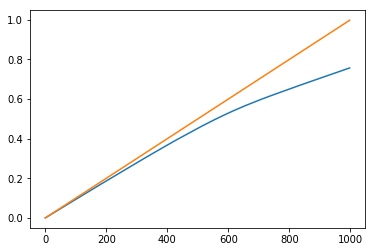

In [64]:
mean = np.sum(np.array(q_ucb), axis=0)/x.shape[0]
regrets = [regret(mean[:i], x_star=0.1) for i in range(len(mean)-1)]
plt.plot(np.array(regrets)/100)
plt.plot(np.arange(len(mean)-1)/1000)

In [ ]:
# now compare against theoretical limits.
# fit a sqrt(T) curve to the data!?

In [ ]:
mean = np.sum(np.array(q_ucb), axis=0)/x.shape[0]


# https://arxiv.org/abs/1807.03765
def lower_bound_regret(H, S, A, T, params):
    return params.a * np.sqrt(np.dot(params.c, np.array([H**4, S, A, T]))) + params.b

def upper_bound_regret(H, S, A, T, params):
    return params.a * np.sqrt(np.dot(params.c, np.array([H**2, S, A, T]))) + params.b

In [ ]:
x.shape, y.shape, error.shape

In [ ]:
class UCB():
    def __init__(self):
        self.atoms = np.linspace(0, 10, self.N)
        self.counts = np.zeros([n_states, n_actions])

    def __call__(self, s, qs):
        # mean + variance
        # utility = exploit + explore
        mean = np.dot(self.atoms, qs[s, ...]) 
        var = np.sum((qs[s, ...] - mean)**2, axis=-1)
        util = mean + var
        # how can we get a better estimate of the variance? delta**2?
        p = softmax(util)
        a = np.random.choice(A, p=p)

        self.counts[s, a] += 1

        return a

class DistributionalQLearner():
    def __init__(self, n_states, n_actions, util_fn):
        self.gamma = 0.9
        self.lr = 0.01
        self.util_fn = util_fn
        self.N = 100

        self.qs = np.zeros([n_states, n_actions, self.N])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = self.util_fn(s, self.qs)
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, self.old_r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
        self.old_r = r
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!